In [ ]:
# default_exp eda

#メモ：ユーザが直接使う上位レイヤ。coreは低レイヤっぽい名前だったので避けた。

# lileda.eda

> 探索的データ分析（EDA）で便利に使える関数を集めたモジュール。  
> liledaは、基本的に本モジュールだけimportして使用する。

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

from tqdm import tqdm
import os
from contextlib import redirect_stdout
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [ ]:
#export
#hide

# ローカル変数 --------------------------------------
_save_dir = Path("./output")  # プロットの自動保存ディレクトリ
            
## ローカル関数 --------------------------------------

pass

# 備考：動作確認用データ

データ分析の定番モジュールの読み込み

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

データ（iris）をdfとして読み込み

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names).merge(
    pd.DataFrame(iris.target).rename(columns={0:"target"})
    , left_index=True, right_index=True
)
df.target = df.target.astype("category")
df.head(1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0


# グローバル関数

In [ ]:
#export
import matplotlib
from matplotlib import font_manager
from distutils.version import LooseVersion
def setup(sub_dir = "", save_dir = "output"):
    """ライブラリの初期設定をする。
    """
    
    # --------------  グラフサイズ設定パラメータ  -----------------------
    size_inch, size_px = 15, 2000  #15, 2000が基本。(15,800)も可能（保存したグラフは見切れる）　　colabは、グラフの横幅[px]が画面の横幅[px]を超えると縮小表示、満たないときはそのままグラフ表示する。

    # 横幅（インチ）を指定したときに、指定pxとなるようなDPIを計算。
    # Jupyter表示時はインチ単位指定だが、ファイル保存時はpx単位になるため。
    _h_inch = size_inch * 9/16
    _dpi = int(size_px / size_inch)
    _fontsize = size_inch * 2  # 15インチ・2kpxなら30px, 5インチ・2kpxなら10px　でちょうどよかった。
    # グラフのデフォルト設定。 ↑と同一セルだと初期化がうまくいかなかった。
    sns.set_style(style="whitegrid")
    plt.rcParams.update({
      'font.size' : _fontsize
      ,'font.family' : 'Meiryo' if os.name == 'nt' else ''  # Colabでは日本語フォントがインストールされてないので注意
      ,'figure.figsize' : [size_inch, _h_inch]  #[20.0, 10.0]
      ,'figure.dpi' : _dpi  #300
      ,'savefig.dpi' : _dpi
      ,'figure.titlesize' : 'large'
      ,'legend.fontsize' : 'small'
      ,'axes.labelsize' : 'medium'
      ,'xtick.labelsize' : 'small'
      ,'ytick.labelsize' : 'small'
      })
    global _save_dir
    _save_dir = Path(save_dir)/sub_dir  #).resolve()
    print(f"lileda> Output directory : '{_save_dir.resolve()}'")
    
    # matplotlibに日本語フォントのインストール ------------------------------
    # 参考：https://github.com/uehara1414/japanize-matplotlib/blob/master/japanize_matplotlib/japanize_matplotlib.py

    FONTS_DIR = 'fonts'
    FONT_NAME = "IPAexGothic"
    FONT_TTF = 'ipaexg.ttf'

    font_dir_path = (Path()/FONTS_DIR).resolve()
    font_files = font_manager.findSystemFonts(fontpaths=[font_dir_path])
    is_support_createFontList = LooseVersion(matplotlib.__version__) < '3.2'
    if is_support_createFontList:
        font_list = font_manager.createFontList(font_files)
        font_manager.fontManager.ttflist.extend(font_list)
    else:
        for fpath in font_files:
            font_manager.fontManager.addfont(fpath)
    matplotlib.rc('font', family=FONT_NAME)


# モジュールを読込んだ時に、デフォルト値で初期設定する。printの出力は捨てる。
with redirect_stdout(open(os.devnull, 'w')):
    setup()


In [ ]:
#hide
# テスト：pltにパラメータが反映されているか

a = dict(plt.rcParams)             # a:actual. pyplotの設定値（辞書形式）
e = {'figure.titlesize' : 'large'
    ,'legend.fontsize' : 'small'
    , 'font.family' : ['IPAexGothic'] }  # e:expected. 期待値
assert {k:a[k] for k in e.keys() if k in a} == e

**Parameters**
- sub_dir : str
  - プロットの自動保存先のディレクトリ。


**使用例１）デフォルトの保存先を確認**

In [ ]:
_save_dir

Path('output')

**使用例２）出力先フォルダを切り替え**

In [ ]:
setup(sub_dir="case1")

lileda> Output directory : '/mnt/e/Users/Chilly/Documents/OneDrive/Codes/Jupyter/lileda/nbs/output/case1'


In [ ]:
#export
def describe(df):
    """DataFrameの要約（統計量や欠損値の数など）を表示する。
    """
    print("データ形式")
    data = df.head(1).copy()
    data.rename(index={0:"0"}, inplace=True)
    dtype_row = pd.DataFrame(data.dtypes).T
    dtype_row.rename(index={0:"dtype"}, inplace=True)
    data = pd.concat([data, dtype_row])
    
    display(data)
    def my_describe(_df):
        smry = _df.describe()
        smry.loc["欠損数"] = _df.isna().sum()
        smry.loc["欠損率"] = smry.loc["欠損数"] / df.index.size * 100
        display(smry.round(3))

    if df.select_dtypes('number').columns.size !=0:
        print("要約統計量（数値）")
        my_describe(df.select_dtypes('number'))
    if df.select_dtypes(exclude='number').columns.size !=0:
        print("要約統計量（数値以外）")
        my_describe(df.select_dtypes(exclude='number'))



**Parameters**
- df : pandas.DataFrame
  - 表示対象のDataFrameインスタンス。


**実行例**

In [ ]:
describe(df)

データ形式


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
dtype,float64,float64,float64,float64,category


要約統計量（数値）


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000,150.000,150.000,150.000
mean,5.843,3.057,3.758,1.199
std,0.828,0.436,1.765,0.762
min,4.300,2.000,1.000,0.100
25%,5.100,2.800,1.600,0.300
50%,5.800,3.000,4.350,1.300
75%,6.400,3.300,5.100,1.800
max,7.900,4.400,6.900,2.500
欠損数,0.000,0.000,0.000,0.000
欠損率,0.000,0.000,0.000,0.000


要約統計量（数値以外）


,target
count,150.0
unique,3.0
top,0.0
freq,50.0
欠損数,0.0
欠損率,0.0


In [ ]:
#export
def savepath(filename):
    """保存先の絶対パスを返す。
    """
    _suffix = ""
    if Path(filename).suffix == '' : _suffix = ".png"
    p = _save_dir/f"{filename}{_suffix}"
    p.parent.mkdir(parents=True, exist_ok=True)
    return p.resolve()


**Parameters**
- filename : str
  - 保存したいファイル名


**利用例**

In [ ]:
savepath("image01")

Path('/mnt/e/Users/Chilly/Documents/OneDrive/Codes/Jupyter/lileda/nbs/output/case1/image01.png')

In [ ]:
#export
def plot(ax_grid, tl=None, xl=None, yl=None, xtl=None, savename=None, ld_out=False):
    """matplotlibやseabornのグラフにタイトル・軸ラベルを設定し、フォントサイズ・グラフサイズを調整して、画像ファイルとして保存する。
    """
    fig=None
    if isinstance(ax_grid, plt.Axes):
        # seabornのAxesレベル関数か、pyplotで生成したグラフの場合
        ax = ax_grid
        fig = ax.figure
        if tl is not None : ax.set_title(tl)
        if xl is not None : ax.set_xlabel(xl)
        if yl is not None : ax.set_ylabel(yl)
        if xtl is not None : ax.set(xtickLabels = xtl)
        if ld_out : ax.legend(loc="upper left", bbox_to_anchor=(1,1))  # 凡例をグラフ枠の外側へ配置
    elif isinstance(ax_grid,  (sns.FacetGrid, sns.PairGrid, sns.JointGrid, sns.pairplot, sns.jointplot)):
        # seaborn のfigureレベル関数で生成したグラフの場合
        g = ax_grid
        fig = g.fig
        # g.fig.set_figheight(size_inch);  g.fig.set_figwidth(size_inch)  # figsizeの修正。あとから修正すると余白やタイトル位置が変になるので、面倒だがグラフ生成のたびにheightで指定することにした。
        if tl is not None : 
            # タイトルを追加するときは、そのまま追加するとファイル保存したときにタイトルが見切れるので、
            # グラフを縦に90%に縮めてタイトルを設置
            g.fig.subplots_adjust(top=0.9)
            g.fig.suptitle(tl)  #, y=1.02
        ax = g.fig.axes[0] #Gridに対しては、最初のAxesにだけラベル名変更などの操作をする
        if xl is not None : ax.set_xlabel(xl)
        if yl is not None : ax.set_ylabel(yl)
        if xtl is not None : ax.set(xtickLabels = xtl)
        if ld_out : ax.legend(loc="upper left", bbox_to_anchor=(1,1))  # 凡例をグラフ枠の外側へ配置
    # save figure
    p = _save_dir; p.mkdir(parents=True, exist_ok=True)
    if savename is not None : fig.savefig(savepath(savename))
    elif tl is not None : fig.savefig(savepath(tl))

**Parameters**
- ax_grid : Union[plt.Axes, sns.FacetGrid, sns.PairGrid, sns.JointGrid, sns.pairplot, sns.jointplot]
  - 処理対象のmatplotlib・seabornグラフ
- tl : str
  - タイトル文字列
- xl : str
  - x軸ラベル
- yl : str
  - y軸ラベル
- xtl : ?
  - x軸の目盛りラベル
- ld_out : bool
  - trueのとき、凡例をグラフ枠の外側へ配置する。

Note:figsizeとtitleのy位置について
- figsizeの指定の仕方によってtitle位置の設定のされ方が違う
- figsizeをsns.jointplot(height=15)のように指定するなら、「, y=1.02」を追加
  - seabornはfigsize指定がpltとは別になっているのでheightパラメータを使う。
  - https://qiita.com/nj_ryoo0/items/9105ddfdf1b08b58398e

**実行例**

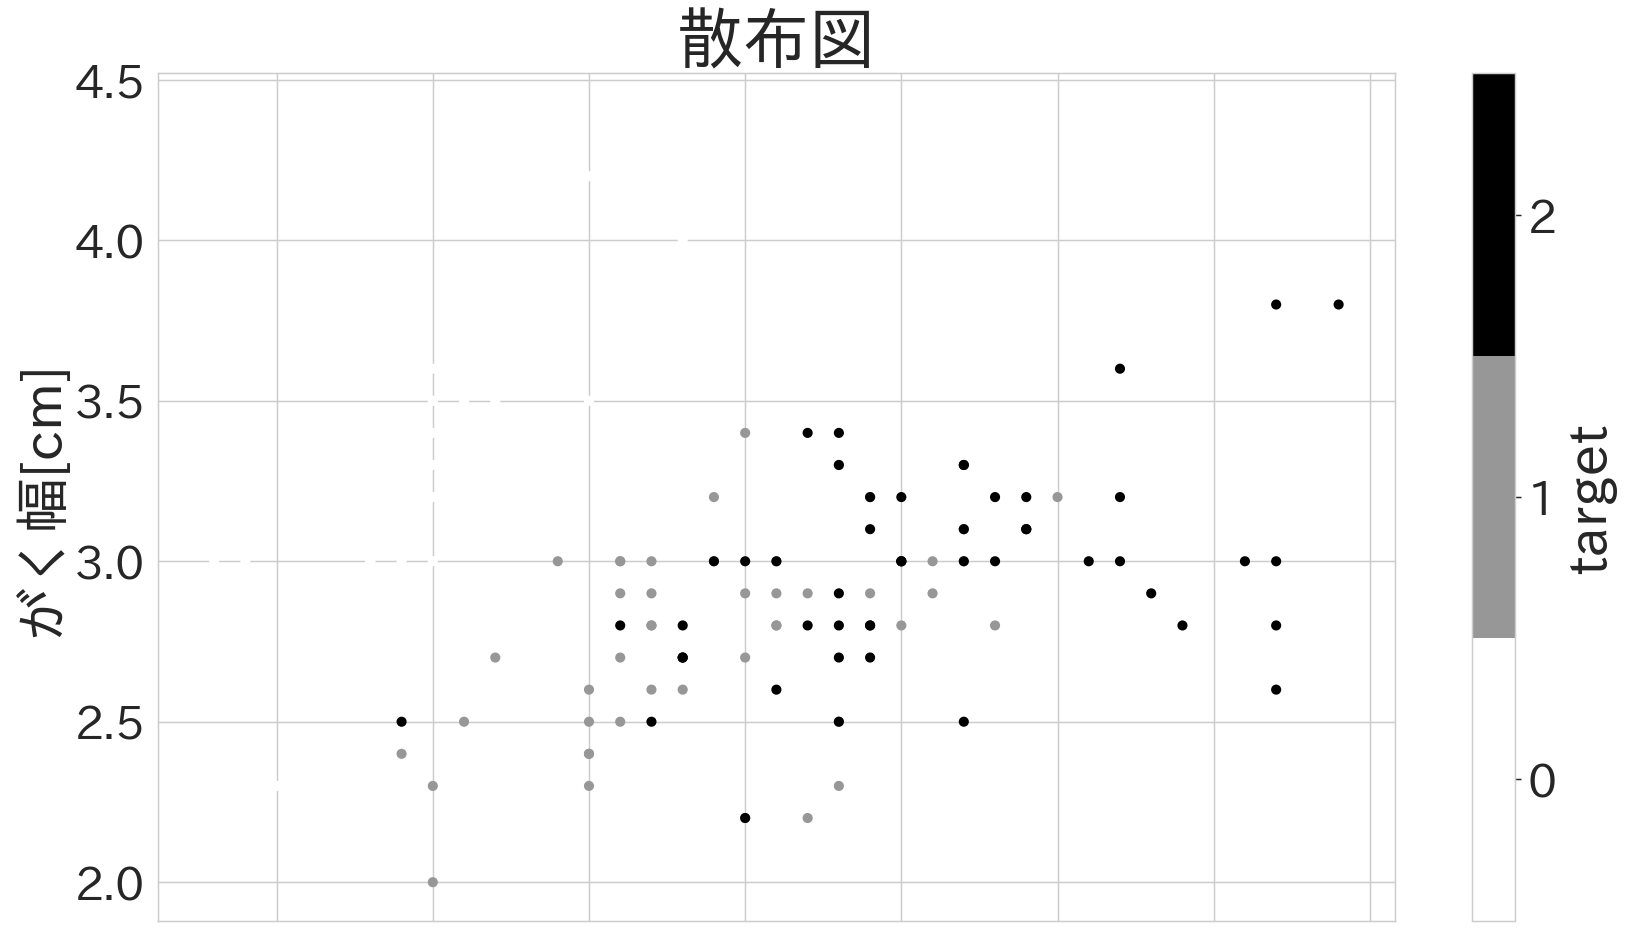

In [ ]:
plot(df.plot.scatter("sepal length (cm)","sepal width (cm)",c="target")
        ,tl="散布図", xl="がく長さ[cm]", yl="がく幅[cm]")

In [ ]:
#hide
# nbdev エクスポート
from nbdev.export import notebook2script; notebook2script()

Converted 00_eda.ipynb.
Converted index.ipynb.
